In [1]:
%pip install deap

Note: you may need to restart the kernel to use updated packages.


Instalar a diblioteca DEAP

pip install deap

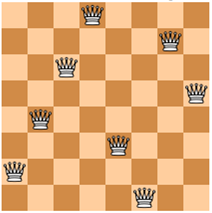

## Cromossomo

### Binário:
[001 011 101 111 010 000 110 100]

### Real:
[1 3 5 7 2 0 6 4]


In [2]:
%pip install matplotlib tqdm

In [3]:
import numpy as np
import random
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
#N = Número de rainhas
N = 128
#log_N = número de bits para representar cada rainha
log_N = int(np.log2(N))


#Funções extraídas do código original do livro
#https://github.com/aimacode/aima-python
def conflicted(state, row, col):
    """Colocar uma rainha em (linha, coluna) causaria algum conflito?"""
    return any(conflict(row, col, state[c], c)
               for c in range(col))

def conflict(row1, col1, row2, col2):
    """Colocar duas rainhas em (linha1, coluna1) e (linha2, coluna2) causaria conflito?"""
    return (row1 == row2 or  # same row
            col1 == col2 or  # same column
            row1 - col1 == row2 - col2 or  # same \ diagonal
            row1 + col1 == row2 + col2)  # same / diagonal

def goal_test(state):
    """Verificar se todas as colunas estão preenchidas sem conflitos."""
    if state[-1] == -1:
        return False
    return not any(conflicted(state, state[col], col)
                   for col in range(len(state)))

def h(node):
    """Retornar o número de rainhas em conflito para um determinado nó"""
    num_conflicts = 0
    for (r1, c1) in enumerate(node):
        for (r2, c2) in enumerate(node):
            if (r1, c1) != (r2, c2):
                num_conflicts += conflict(r1, c1, r2, c2)
    return num_conflicts

def nqueen_fitness(node):
    node_int = []
    for i in range(0, len(node), log_N):
        a = map(str, node[i:i+log_N])    
        node_int.append(int(''.join(a), 2))

    return h(node_int),
    
def plot_solution(solution, N):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, N))
    ax.set_ylim((0, N))

    # Adicionar quadriculado
    for i in range(N):
        for j in range(N):
            color = 'white' if (i + j) % 2 == 0 else 'black'
            ax.add_patch(patches.Rectangle((j, i), 1, 1, color=color))
    
    count = 0
    for queen in solution:
        ax.add_patch(patches.Circle((queen + 0.5, count + 0.5), radius=0.4, fill=True, color='red'))
        count += 1
    plt.show()

In [5]:
#Cria ferramenta de geração de indivíduos
creator.create("Fitness", base.Fitness, weights=(-1.0, )) #Peso -1 por ser um problema de minimização

#Cada indíviduo é composto por um cromossomo que é uma lista de valores
creator.create("Individual", list, fitness=creator.Fitness)

In [6]:
#Toolbox é onde definiremos os operadores para a execução
toolbox = base.Toolbox()

#Função para criação do cromossomo
#x = 0|1
toolbox.register("attr_bool", random.randint, 0, 1) #np.random.randint(0,1)
#Função para Definir a criação do indivíduo. Será feita a repetição da função attr_bool por n vezes
#cromossomo = [x, x, x, x, ..., x]     len(cromossomo) = n
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N*log_N)
#Função para criar população. Repetição de indivíduos para formar uma lista
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [7]:
#função de avaliação
toolbox.register("evaluate", nqueen_fitness)
#função de cruzamento
toolbox.register("mate", tools.cxOnePoint)
#função de mutação
#indpb probabilidade de mutação em bit
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
#função de seleção
"""
tournsize quantidade de individuos selecionados aleatoriamente
para participar do torneio para se tornar o pai da proxima geração
"""
toolbox.register("select", tools.selTournament, tournsize=5)

Operadores do framework DEAP

https://deap.readthedocs.io/en/master/api/tools.html

In [8]:
from tqdm import tqdm

"""
É comum em algoritmos genéticos, onde você começa com uma 
pequena população inicial e, em seguida, a população cresce 
e evolui ao longo das gerações.
"""
media = 0

for _ in range(1):
    #Inicia população con n indivíduos
    population = toolbox.population(n=1000)

    #Número máximo de gerações
    NGEN=50

    #Avalia todos os indivíduos
    fits = toolbox.map(toolbox.evaluate, population)
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit  
        
    avg = []
    tops = []
    worsts = []
    print(f'=================== RODADA {_} ===================')
    for gen in tqdm(range(NGEN)):
        #Faz seleção
        population = toolbox.select(population, k=len(population))
        #Faz o cruzamento e mutação
        #cxpb = probabilidade de cruzamento
        #mutpb = probabilidade de mutação
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.9, mutpb=0.1)
        
        #Reavalia a nova geração
        avg_h = 0
        fits = toolbox.map(toolbox.evaluate, offspring) 
        for fit, ind in zip(fits, offspring):
            avg_h += fit[0]
            ind.fitness.values = fit
            
        #nova população vão ser os filhos
        population[:] = offspring
            
        #pega melhor e pior indivíduos para montar o gráfico
        top = tools.selBest(population, k=1)
        worst = tools.selWorst(population, k=1)
        
        #calcula a média da população 
        avg_h = avg_h/len(population)
        #pega a quantidade de conflitos do melhor e pior individuo 
        top_h = nqueen_fitness(top[0])[0]
        worst_h = nqueen_fitness(worst[0])[0]

        #adiciona nas listas os dados obtidos da atual geração
        avg.append(avg_h)
        tops.append(top_h)
        worsts.append(worst_h)
        
        #Avalia critério de parada
        if(nqueen_fitness(top[0])[0] == 0): break
            
    print(f'Melhor individuo contem {nqueen_fitness(top[0])} conflitos ')
    media += nqueen_fitness(top[0])[0]
    print(f'================================================\n')
print(f'Media: {media/5}')

=================== RODADA 0 ===================


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]

Melhor individuo contem (112,) conflitos 

Media: 22.4


In [9]:
print(f'Melhor individuo contem : {nqueen_fitness(top[0])} conflitos')

Melhor individuo contem : (112,) conflitos


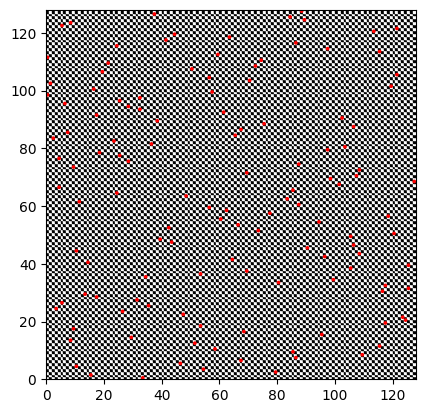

In [10]:
node_int = []
for i in range(0, len(top[0]), log_N):
    a = map(str, top[0][i:i+log_N])    
    node_int.append(int(''.join(a), 2))
    
plot_solution(node_int, N)

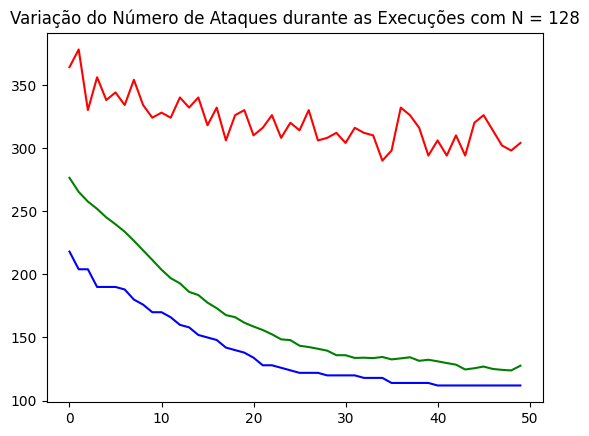

In [11]:
plt.plot(avg, c='g')
plt.plot(tops, c='b')
plt.plot(worsts, c='r')
plt.title(f'Variação do Número de Ataques durante as Execuções com N = {N}')
plt.show()

In [12]:
print(node_int)

[33, 15, 79, 54, 10, 46, 67, 86, 109, 85, 58, 115, 51, 8, 29, 95, 68, 9, 53, 117, 124, 123, 47, 26, 3, 35, 5, 31, 17, 13, 116, 125, 117, 80, 99, 34, 53, 69, 105, 125, 14, 64, 96, 108, 10, 90, 106, 43, 39, 105, 120, 73, 42, 66, 94, 60, 118, 77, 62, 56, 87, 11, 83, 48, 24, 85, 4, 101, 127, 98, 107, 69, 108, 9, 87, 28, 4, 25, 18, 97, 103, 36, 23, 2, 65, 7, 67, 106, 75, 38, 102, 17, 61, 32, 28, 6, 25, 32, 0, 57, 16, 119, 1, 70, 56, 121, 19, 50, 72, 21, 74, 0, 59, 115, 97, 24, 86, 41, 63, 44, 113, 121, 5, 8, 89, 84, 37, 88]
